In [1]:
import netCDF4 as nc
import sys, os, argparse
import time
import numpy as np
from numpy import ma as ma

#Import packages for plotting
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import matplotlib.animation as animation
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from pylab import imshow,cm

from pylab import imshow,cm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  

#Import packages for clustering
from sklearn.cluster import KMeans
from scipy.linalg import eigh

#Import packages for geodesic distences
from pyproj import Geod

# Import package for parallel computing
from joblib import Parallel, delayed

from scipy.interpolate import griddata

from pylab import imshow,cm
import cartopy.crs as ccrs 
import cartopy.feature as cfeature  



parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering/"
geodesic=True
e=0

# add utils folder to the TBarrier package
#sys.path.append(T_Barrier_directory+"/subfunctions/utils")
#sys.path.append(T_Barrier_directory+"/subfunctions/integration")
# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/border_calculation")
sys.path.append(parent_directory+"/utils")

sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/utils")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
sys.path.append(parent_directory+"/subfunctions/latlon_transform") 
from parallelised_functions import split3D

sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
from Interpolant import generate_land_mask_interpolator 

from from_similarity_to_eigen import from_similarity_to_eigen, from_similarity_to_eigen_W, cut_trajectories_in_W #, from_similarity_to_eigen_cut_zones

from ploters import ini_final_clusters
from ploters import gif_clusters
from ploters import ini_final_clusters_landmask
from ploters import ini_final_clusters_landmask_ini
from ploters import gif_clusters_landmask
from degrees import degree_matrix
from polar_rotation import polar_rotation_rx 
from calculating_borders import borders_binary

seasons = "JFM OND AMJ JAS"
# Split the string into a list of seasons
season_list = seasons.split()


In [2]:

def ini_final_clusters_landmask_borders(borders_avg, img_name, e, x, y, x_reg, y_reg, land_mask_plot,min_clusters,max_clusters,vmin,vmax):

    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()

    fig, ax = plt.subplots(figsize=(8, 6))
    # Define color map for the landmask
    #colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    #colors_mask = [(0.0, 0.0, 0.5), (1, 1, 1)]  # Deep blue and white
    colors_mask = [(0.968, 0.984, 1.0), (1, 1, 1)]  # Lightest blue in "Blues" and white
    #colors_mask = [(0.969, 0.969, 0.969), (1, 1, 1)]  # Lightest grey in "Greys" and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Interpolate the labels onto the grid


    #ax.pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)
    # Plot the initial distribution
    ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=land_mask_plot, cmap=colors_mask)
    im1 = ax.pcolormesh(x_reg,y_reg,borders_avg*100,cmap="Blues",alpha=1,vmin=vmin,vmax=vmax)
    

    #ax.imshow(mask_interpol, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone')
    
    contour_land = ax.contour(x, y, land_mask_plot, levels=0, cmap='bone', alpha=1)

    #im1 = ax.imshow(masked_borders_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r', alpha=0.7)

    # Add contour plot to the first subplot
    #contour_land = ax.contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
    ax.set_xlabel("Rotated Longitude", fontsize=16)
    ax.set_ylabel("Rotated Latitude", fontsize=16)
    ax.set_title("Frequency of cluster borders - "+str(min_clusters)+" to "+str(max_clusters)+" clusters")
    ax.set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
    ax.set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
    ax.set_aspect('equal', 'box')

    cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    cbar.set_label('%', fontsize=16)  # Optional: add a label to the colorbar
    # Main title
    #plt.suptitle(f"{n_clusters} clusters_{e} spars", fontsize=16)
    plt.subplots_adjust(right=0.8) 
    # Save the figure
    plt.savefig(f"{img_name}")
    # Show the plot
    plt.show()


In [3]:
def ini_final_clusters_landmask_borders_scalar(borders_avg, img_name, e, x, y, x_reg, y_reg, land_mask_plot,min_clusters,max_clusters,scalar):

    ymax = y.max()
    ymin = y.min()
    xmax = x.max()
    xmin = x.min()

    fig, ax = plt.subplots(figsize=(8, 6))
    # Define color map for the landmask
    #colors_mask = [(0.58, 0.747, 0.972), (1, 1, 1)]  # Light blue and white
    #colors_mask = [(0.0, 0.0, 0.5), (1, 1, 1)]  # Deep blue and white
    colors_mask = [(0.968, 0.984, 1.0), (1, 1, 1)]  # Lightest blue in "Blues" and white
    #colors_mask = [(0.969, 0.969, 0.969), (1, 1, 1)]  # Lightest grey in "Greys" and white
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("GreyToBlue", colors_mask)
    colors_mask = plt.get_cmap(custom_cmap, 2)
    # Interpolate the labels onto the grid

    scalar_ini = scalar[0, :, :]  # Assuming you want to show the first time slice
    #axes[0].pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)

    #axes[0].pcolormesh(x, y, scalar_ini, cmap="bone_r", alpha=1)
    im1 = ax.imshow(scalar_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r')
    #ax.pcolor(x,y,fmap_mask,cmap="Greys",alpha=1)
    # Plot the initial distribution
    ax.scatter(x.ravel(), y.ravel(), marker='.', s=0.1, c=land_mask_plot, cmap=colors_mask)
    borders_avg = np.where(borders_avg <= 0.4, np.nan, borders_avg)
    im2 = ax.pcolormesh(x_reg,y_reg,borders_avg*100,cmap="Blues",alpha=1) #,vmin=0,vmax=40)
    

    #ax.imshow(mask_interpol, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone')
    
    contour_land = ax.contour(x, y, land_mask_plot, levels=0, cmap='bone', alpha=1)

    #im1 = ax.imshow(masked_borders_ini, extent=(xmin, xmax, ymin, ymax), origin='lower', cmap='bone_r', alpha=0.7)

    # Add contour plot to the first subplot
    #contour_land = ax.contour(x, y, mask_interpol, levels=1, cmap='viridis', alpha=0.5)
    ax.set_xlabel("Rotated Longitude", fontsize=16)
    ax.set_ylabel("Rotated Latitude", fontsize=16)
    ax.set_title("Frequency of cluster borders - "+str(min_clusters)+" to "+str(max_clusters)+" clusters")
    ax.set_xlim(xmin-0.05*(xmax-xmin), xmax+0.05*(xmax-xmin)) 
    ax.set_ylim(ymin-0.05*(xmax-xmin), ymax+0.05*(ymax-ymin))  
    ax.set_aspect('equal', 'box')

    cbar = fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
    #cbar = plt.colorbar(im1, orientation='vertical')
    cbar.set_label('Sea ice thickness (m)')  # Optional: add a label to the colorbar

    cbar = fig.colorbar(im2, ax=ax, orientation='vertical', fraction=0.046, pad=0.15)
    cbar.set_label('%', fontsize=16)  # Optional: add a label to the colorbar
    # Main title
    #plt.suptitle(f"{n_clusters} clusters_{e} spars", fontsize=16)
    plt.subplots_adjust(right=0.8) 
    # Save the figure
    plt.savefig(f"{img_name}")
    # Show the plot
    plt.show()

In [4]:
def plot_clusters_3w(Fmap, n_clusters, labels_reweighted, labels_disp, labels, cmap): 
    # Define a diverging colormap and normalization centered at 1 with an asymmetric range
    #vlim_reweighted = max(abs(1-w_reweighted.min()),abs(1-w_reweighted[w_reweighted<w_reweighted.max()].max()))
    #vlim_disp = max(abs(1-w_disp.min()),abs(1-w_disp[w_disp<w_disp.max()].max()))
    IC = Fmap[0,:,:]
    IC_lat, IC_lon = polar_rotation_rx(IC[1], IC[0],-90) 
    positions_ini = np.asarray(np.vstack((IC_lon,IC_lat))) 

    # Create a figure with two subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3,  # 1 row, 2 columns
        figsize=(24, 8),  # Adjust the figure size
        subplot_kw={"projection": ccrs.NorthPolarStereo()}  # North Polar Stereographic projection
    )

    # Define a color map for the clusters
    colors = plt.get_cmap(cmap, n_clusters)
    #cluster_names = [f"Cluster {i+1}" for i in range(n_clusters)]  # Names for legend

    # Plot the first subplot with w_reweighted
    # Plot the initial distribution
    ax1.scatter(positions_ini[0, :], positions_ini[1, :], c=labels_reweighted, cmap=colors, vmin=0, vmax=n_clusters-1,transform=ccrs.PlateCarree(), s=8)
    ax1.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax1.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl1.xlocator = plt.MultipleLocator(45)  # Longitude gridlines every 45 degrees
    gl1.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    ax1.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax1.set_title("IC/Lagrangian distance ", fontsize=20)
  
    # Plot the second subplot with w_disp
    ax2.scatter(positions_ini[0, :], positions_ini[1, :], c=labels_disp, cmap=colors, vmin=0, vmax=n_clusters-1,transform=ccrs.PlateCarree(), s=8)
    ax2.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl1 = ax2.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl1.xlocator = plt.MultipleLocator(45)  # Longitude gridlines every 45 degrees
    gl1.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    ax2.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax2.set_title("IC/FC", fontsize=20)

    # Plot the second subplot with w_vec
    ax3.scatter(positions_ini[0, :], positions_ini[1, :], c=labels, cmap=colors, vmin=0, vmax=n_clusters-1,transform=ccrs.PlateCarree(), s=8)
    ax3.coastlines(resolution='50m', color='black', linewidth=0.8)
    gl2 = ax3.gridlines(draw_labels=False, color='gray', linestyle='--', linewidth=0.5)
    gl2.xlocator = plt.MultipleLocator(45)  # Longitude gridlines every 45 degrees
    gl2.ylocator = plt.MultipleLocator(35)  # Latitude gridlines every 35 degrees
    ax3.set_extent([-180, 180, 65, 90], crs=ccrs.PlateCarree())
    ax3.set_title("Lagrangian distance", fontsize=20)
    fig.suptitle(f"Cluster analysis for different metrics ({n_clusters} clusters)", fontsize=24)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()
    # plt.savefig(img_name, bbox_inches='tight')  # Save the figure if needed
    #plt.close(fig)  # Close the figure to free up memory

In [5]:
# Get the parent directory
parent_directory = "/cluster/home/llpui9007/Programs/HPC_Spectral_Clustering"
FTLE_parent_directory = "/cluster/home/llpui9007/Programs/FTLE"
TBarrier_parent_directory = "/cluster/home/llpui9007/Programs/TBarrier-main/TBarrier/2D"


# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_clustering")
sys.path.append(parent_directory+"/subfunctions/Similarity_matrix_construction")
sys.path.append(parent_directory+"/subfunctions/trajectory_advection")
sys.path.append(parent_directory+"/subfunctions/Parallelisation")
sys.path.append(parent_directory+"/subfunctions/latlon_transform")
sys.path.append(parent_directory+"/utils")
sys.path.append(FTLE_parent_directory)
# add utils folder to current working path
sys.path.append(TBarrier_parent_directory+"/subfunctions/utils")
# add integration folder to current working path
sys.path.append(TBarrier_parent_directory+"/subfunctions/integration")
# add FTLE folder to current working path
sys.path.append(TBarrier_parent_directory+"/demos/AdvectiveBarriers/FTLE2D")


# Import linear interpolation function for unsteady flow field with irregular grid
from Interpolant import generate_mask_interpolator , generate_velocity_interpolants
# Import function to compute flow map/particle trajectories
from regular_regrid import regular_grid_interpolation_scalar
from polar_rotation import polar_rotation_rx 

#Parallelisation folder
from NetCDF_generator import generate_regrided

# Import function to compute gradient of flow map
from gradient_flowmap import gradient_flowmap
from gradient_flowmap_support import interpolant_unsteady
# Import function to compute finite time Lyapunov exponent (FTLE)
from FTLE import parallel_FTLE
from ploters import plotpolar_scatter_masked_ftle
from days_since_to_date import days_since_to_date


In [6]:
geo_file_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/OPA-neXtSIM_CREG025_ILBOXE140_2009_ice_90Rx_AMJ_regrided.nc"
backgrun_file_path = "/cluster/projects/nn8008k/lluisa/NextSIM/seas/OPA-neXtSIM_CREG025_ILBOXE140_2009_ice_90Rx_AMJ.nc"
file_path="/cluster/projects/nn8008k/lluisa/NextSIM/seas/Fmap/2009_AMJ_ic0.5_dt0.0025_DT0.1000/"

dataset = nc.Dataset(geo_file_path, mode='r')

#from m/s to m/day
land_mask = dataset.variables['land_mask'][:]
latitude_reg = dataset.variables['regrided_rot_lat'][:]  
longitude_reg = dataset.variables['regrided_rot_lon'][:]
sit = dataset.variables['sit'][:,:,:]
dataset.close()

dataset = nc.Dataset(backgrun_file_path, mode='r')
# Access coordinates
latitude = dataset.variables['rot_lat'][:]  
longitude = dataset.variables['rot_lon'][:]
siu = dataset.variables['vlon'][0,:,:]
land_mask_plot = siu[:,:].mask
dataset.close()

x=longitude
y=latitude
x_reg=longitude_reg
y_reg=latitude_reg

clusters_path = file_path+'clusters_K10000000_border4.00/'

In [7]:
def prepare_calculate_ftle_in_coordinates(reg_vel_file_path,dic,  aux_grid_ratio, dt,tmin,tmax, NCores):
    # Read dataset
    print("Reading regrided input data")
    dataset = nc.Dataset(reg_vel_file_path, mode='r')
    #from m/s to m/day
    interpolated_siu = dataset.variables['vlon'][tmin:tmax,:,:]
    interpolated_siv = dataset.variables['vlat'][tmin:tmax,:,:]
    interpolated_siu = np.transpose(interpolated_siu, axes=(1, 2, 0))
    interpolated_siv = np.transpose(interpolated_siv, axes=(1, 2, 0))
    regrided_land_mask = dataset.variables['land_mask'][:,:]
    # Access coordinates
    lat_grid = dataset.variables['regrided_rot_lat'][:]  
    lon_grid = dataset.variables['regrided_rot_lon'][:]
    # Access specific variables
    time_data = dataset.variables['time'][tmin:tmax] 
    time_data= np.reshape(time_data, (1,-1))
    dataset.close()


    # Find the points where the velocity arrays are 0. This means either land or null initial velocity and therefore we don't 
    # want to have IC there.
    #vel_land_interpolator = generate_mask_interpolator(lat_grid,lon_grid,interpolated_siu,interpolated_siv)
    print("Interpolating the velocity field")
    print("shape of interpolated siu: "+str(interpolated_siu.shape))
    Interpolant_u, Interpolant_v = generate_velocity_interpolants(interpolated_siu, interpolated_siv,lon_grid, lat_grid, NCores)

    lat_grid = lat_grid.filled()
    lon_grid = lon_grid.filled()


    # Time resolution of data
    dt_data = time_data[0, 1]-time_data[0,0] # float

    # Periodic boundary conditions
    periodic_x = False # bool
    periodic_y = False # bool
    periodic_t = False # bool
    periodic = [periodic_x, periodic_y, periodic_t]

    # Unsteady velocity field
    bool_unsteady = True # bool

    # Defined domain
    defined_domain = np.isfinite(interpolated_siu[:,:,0]).astype(int) # array (NY, NX)


    # Initial time (in days)
    t0 = time_data[0,0] # float

    # Final time (in days)
    tN = time_data[0,-1] # float

    # NOTE: For computing the backward trajectories: tN < t0 and dt < 0.

    time = np.arange(t0, tN+dt, dt) # shape (Nt,)

    # Length of time interval (in days)
    lenT = abs(tN-t0) # float



    # Define ratio of auxiliary grid spacing vs original grid_spacing
    aux_grid = [aux_grid_ratio*dic, aux_grid_ratio*dic] # list (2, )

    return time, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, lon_grid,lat_grid, aux_grid



In [8]:
# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))


In [9]:

def calculate_ftle_in_coordinates_ready(time, x0, y0, X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid, NCores):

    x0_batch = list(split(x0, NCores)) # list (Nx*Ny)
    y0_batch = list(split(y0, NCores)) # list (Nx*Ny)


    # compute FTLE
    results = Parallel(n_jobs=NCores, verbose = 50)(delayed(parallel_FTLE)(time, x0_batch[i], y0_batch[i], X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) for i in range(len(x0_batch)))

    # Extract FTLE from results of parallel computing
    FTLE = results[0]

    for res in results[1:]:
        FTLE = np.append(FTLE, res)

    #Land mask: water 0, land 1
    #mask_interpolator = LNDI(list(zip(lat_grid.ravel(), lon_grid.ravel())), regrided_land_mask.ravel(),fill_value=1)
    #ftle_land_mask=mask_interpolator(Y_domain,X_domain)
    #masked_ftle = np.ma.masked_array(FTLE, mask=ftle_land_mask)
    return FTLE #masked_ftle




In [10]:
def calculate_ftle_in_coordinates(x0,y0,reg_vel_file_path,dic,  aux_grid_ratio, dt,tmin,tmax, NCores):
    # Read dataset
    print("Reading regrided input data")
    dataset = nc.Dataset(reg_vel_file_path, mode='r')
    #from m/s to m/day
    interpolated_siu = dataset.variables['vlon'][tmin:tmax,:,:]
    interpolated_siv = dataset.variables['vlat'][tmin:tmax,:,:]
    interpolated_siu = np.transpose(interpolated_siu, axes=(1, 2, 0))
    interpolated_siv = np.transpose(interpolated_siv, axes=(1, 2, 0))
    # Access coordinates
    lat_grid = dataset.variables['regrided_rot_lat'][:]  
    lon_grid = dataset.variables['regrided_rot_lon'][:]
    # Access specific variables
    time_data = dataset.variables['time'][tmin:tmax] 
    time_data= np.reshape(time_data, (1,-1))
    dataset.close()


    # Find the points where the velocity arrays are 0. This means either land or null initial velocity and therefore we don't 
    # want to have IC there.
    #vel_land_interpolator = generate_mask_interpolator(lat_grid,lon_grid,interpolated_siu,interpolated_siv)
    print("Interpolating the velocity field")
    print("shape of interpolated siu: "+str(interpolated_siu.shape))
    Interpolant_u, Interpolant_v = generate_velocity_interpolants(interpolated_siu, interpolated_siv,lon_grid, lat_grid, NCores)

    lat_grid = lat_grid.filled()
    lon_grid = lon_grid.filled()


    # Time resolution of data
    dt_data = time_data[0, 1]-time_data[0,0] # float

    # Periodic boundary conditions
    periodic_x = False # bool
    periodic_y = False # bool
    periodic_t = False # bool
    periodic = [periodic_x, periodic_y, periodic_t]

    # Unsteady velocity field
    bool_unsteady = True # bool

    # Defined domain
    defined_domain = np.isfinite(interpolated_siu[:,:,0]).astype(int) # array (NY, NX)

    ## Compute meshgrid of dataset
    X, Y =  lon_grid, lat_grid # array (NY, NX)

    ## Resolution of meshgrid
    dx_data = X[0,1]-X[0,0] # float
    dy_data = Y[1,0]-Y[0,0] # float

    delta = [dx_data, dy_data] # list (2, )


    # Initial time (in days)
    t0 = time_data[0,0] # float

    # Final time (in days)
    tN = time_data[0,-1] # float

    # NOTE: For computing the backward trajectories: tN < t0 and dt < 0.

    time = np.arange(t0, tN+dt, dt) # shape (Nt,)

    # Length of time interval (in days)
    lenT = abs(tN-t0) # float



    # Define ratio of auxiliary grid spacing vs original grid_spacing
    aux_grid = [aux_grid_ratio*dic, aux_grid_ratio*dic] # list (2, )


    # Split x0, y0 into 'Ncores' equal batches for parallel computing
    def split(a, n):
        k, m = divmod(len(a), n)
        return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

    x0_batch = list(split(x0, NCores)) # list (Nx*Ny)
    y0_batch = list(split(y0, NCores)) # list (Nx*Ny)


    # compute FTLE
    results = Parallel(n_jobs=NCores, verbose = 50)(delayed(parallel_FTLE)(time, x0_batch[i], y0_batch[i], X, Y, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid) for i in range(len(x0_batch)))

    # Extract FTLE from results of parallel computing
    FTLE = results[0]

    for res in results[1:]:
        FTLE = np.append(FTLE, res)

    return FTLE #masked_ftle




In [11]:

#ftle = calculate_ftle_in_coordinates(x_reg,y_reg,geo_file_path,0.5,0.01,0.1,0,-1,30) 
time, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, lon_grid, lat_grid, aux_grid = prepare_calculate_ftle_in_coordinates(reg_vel_file_path=geo_file_path,dic=0.5,  aux_grid_ratio=0.01, dt=0.1,tmin=0,tmax=-1, NCores=32)
print("Done making the ftle calculation ready, starting!")


Reading regrided input data
Interpolating the velocity field
shape of interpolated siu: (507, 449, 363)
Generate interpolators for the advection
Time taken for parallel computation to generate the velocity interpolator objects: 7.89 seconds
Done making the ftle calculation ready, starting!


In [12]:
formatted_d=str(0)
clusters_path = file_path+'clusters_K10000000_border0.00/'
FTLE = []
for i in range (10, 25,2):
    print("Processing "+str(i)+" clusters")
    n_clusters=i
    Fmap_path = clusters_path+str(n_clusters)+'_Fmap_cut.npy'
    labels_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels.npy'
    labels_disp_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_disp.npy'
    labels_reweighted_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_reweighted.npy'

    Fmap = np.load(Fmap_path)
    labels= np.load(labels_path)
    labels_disp = np.load(labels_disp_path)
    labels_reweighted = np.load(labels_reweighted_path)

    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    grid_labels = griddata((IC[0, :], IC[1, :]), labels_disp, (lon_grid,lat_grid), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels_disp, (lon_grid,lat_grid), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(fmap_mask,np.nan, borders_avg)
    borders_idx = np.where(borders_avg==1)
    borders_lon_rot = lon_grid[borders_idx]
    borders_lat_rot = lat_grid[borders_idx]
    FTLE.append(calculate_ftle_in_coordinates_ready(time, borders_lon_rot, borders_lat_rot, lon_grid, lat_grid, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid, NCores=1))


Processing 10 clusters
3052
0
1000
2000
3000
[Parallel(n_jobs=1)]: Done   0 tasks      | elapsed:   46.9s


KeyboardInterrupt: 

In [17]:
mean_FTLE = []
idx = []
for i in range(0,len(FTLE)):
    mean_FTLE.append(np.mean(FTLE[i]))
    idx.append(20+i*5)

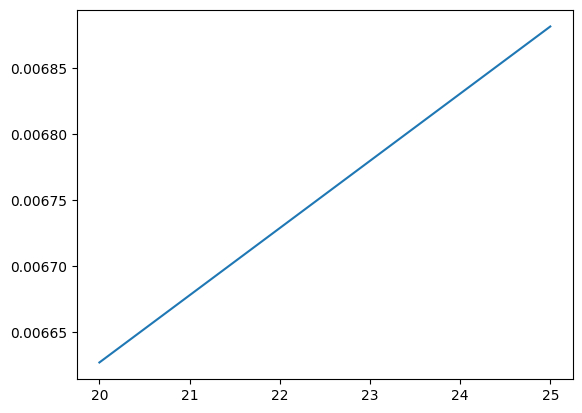

In [18]:
plt.plot(idx,mean_FTLE)

In [ ]:

FTLE = calculate_ftle_in_coordinates_ready(time, borders_lon_rot, borders_lat_rot, lon_grid, lat_grid, Interpolant_u, Interpolant_v, periodic, defined_domain, bool_unsteady, time_data, aux_grid, NCores=20)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
210
0
210
0
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   18.5s
210
0
[Parallel(n_jobs=20)]: Done   2 out of  20 | elapsed:   22.3s remaining:  3.4min
210
0
[Parallel(n_jobs=20)]: Done   3 out of  20 | elapsed:   26.6s remaining:  2.5min
210
0
210
0
[Parallel(n_jobs=20)]: Done   4 out of  20 | elapsed:   31.7s remaining:  2.1min
210
0
[Parallel(n_jobs=20)]: Done   5 out of  20 | elapsed:   36.3s remaining:  1.8min
[Parallel(n_jobs=20)]: Done   6 out of  20 | elapsed:   39.7s remaining:  1.5min
210
0
[Parallel(n_jobs=20)]: Done   7 out of  20 | elapsed:   43.9s remaining:  1.4min
210
0
210
0
[Parallel(n_jobs=20)]: Done   8 out of  20 | elapsed:   48.8s remaining:  1.2min
210
0
[Parallel(n_jobs=20)]: Done   9 out of  20 | elapsed:   53.4s remaining:  1.1min
210
0
[Parallel(n_jobs=20)]: Done  10 out of  20 | elapsed:   57.2s remaining:   57.2s
209
0
[Parallel(n_jobs=20)]: Done  11 out of  20 | elapsed: 

In [62]:
np.mean(FTLE)

np.float64(0.006706217417596527)

In [26]:
# Define the 30 qualitative colors
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3", "#8ca252", "#bd9e39", "#ad494a", "#a55194"
]
# Create a ListedColormap
cmap = ListedColormap(colors, name='qualitative_30')

NameError: name 'ListedColormap' is not defined

In [ ]:
n_clusters=35
kmeans_3w(n_clusters,l_vect_reweighted,l_vect_disp,l_vect,Fmap_cut,d)
# Define the 30 qualitative colors
colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5", "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#393b79", "#637939", "#8c6d31", "#843c39", "#7b4173", "#5254a3", "#8ca252", "#bd9e39", "#ad494a", "#a55194"
]
# Create a ListedColormap
cmap = ListedColormap(colors, name='qualitative_30')
plot_clusters_3w(Fmap, n_clusters, labels_reweighted, labels_disp, labels, cmap)

plot_clusters_3w(Fmap, n_clusters, labels_reweighted, labels_disp, labels, cmap)

In [24]:
plot_clusters_3w(Fmap, n_clusters, labels_reweighted, labels_disp, labels, "")


NameError: name 'Fmap' is not defined

In [16]:
def process_clusters(min_clusters, max_clusters, clusters_path=clusters_path, x_reg=x_reg, y_reg=y_reg, results_directory="./", Cluster_params="", e=e, longitude=longitude, latitude=latitude, land_mask_plot=land_mask_plot, ):
    formatted_d=str(0)
    clusters_path = file_path+'clusters_K10000000_border4.00/'
    Fmap_path = clusters_path+str(min_clusters)+'_Fmap_cut.npy'
    labels_path = clusters_path+str(min_clusters)+'_d'+str(formatted_d)+'_labels_disp.npy'
    # Load the Fmap array from the file
    Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
    IC = Fmap[0,:,:]  #Take the position of the trajectory IC
    # Load the labels of the clusters
    labels= np.load(labels_path)


    grid_labels = griddata((IC[0, :], IC[1, :]), labels, (x_reg,y_reg), method='nearest')
    fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels, (x_reg,y_reg), method='linear'))
    borders_avg = borders_binary(grid_labels)
    borders_avg = np.where(fmap_mask,np.nan, borders_avg)
    borders_avg[borders_avg > 0] = 1
    for n_clusters in range(min_clusters+1, max_clusters+1):
        # Construct the file paths with the current value of n_clusters
        print("processing cluster "+str(n_clusters))
        Fmap_path = clusters_path+str(n_clusters)+'_Fmap_cut.npy'
        labels_path = clusters_path+str(n_clusters)+'_d'+str(formatted_d)+'_labels_disp.npy'
        
        # Load the Fmap array from the file
        Fmap = np.load(Fmap_path)  # ntime [lon,lat] ntrajectories
        IC = Fmap[0, :, :]  # Take the position of the trajectory IC
        
        # Load the labels of the clusters
        labels = np.load(labels_path)
        
        # Interpolate the labels onto the grid
        grid_labels = griddata((IC[0, :], IC[1, :]), labels, (x_reg, y_reg), method='nearest')
        fmap_mask = np.isnan(griddata((IC[0, :], IC[1, :]), labels, (x_reg, y_reg), method='linear'))
        
        # Calculate borders
        borders = borders_binary(grid_labels)
        borders = np.where(fmap_mask, np.nan, borders)
        borders[borders > 0] = 1
        
        # Accumulate the borders
        borders_avg += borders
    
    # After the loop, borders_avg will contain the accumulated borders
    borders_avg = np.where(borders_avg == 0, np.nan, borders_avg)
    borders_avg = np.where(land_mask == 1, np.nan, borders_avg)
    borders_avg = borders_avg / (max_clusters-min_clusters)
    # Call the final processing function
    ini_final_clusters_landmask_borders(borders_avg, results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg, land_mask_plot, min_clusters, max_clusters,0,100)
    return borders_avg
                                                    
# Example usage:
# process_clusters(file_path, x_reg, y_reg, land_mask, ntimesteps, results_directory, Cluster_params, e, longitude, latitude, land_mask_plot)

In [53]:
borders_2_10.shape

(507, 449)

processing cluster 3
processing cluster 4
processing cluster 5
processing cluster 6
processing cluster 7
processing cluster 8
processing cluster 9
processing cluster 10


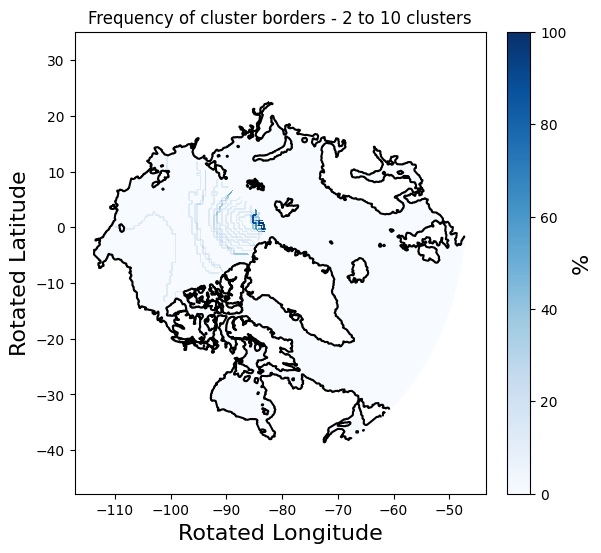

In [17]:
borders_2_10 = process_clusters(2,10)

processing cluster 3
processing cluster 4
processing cluster 5
processing cluster 6
processing cluster 7
processing cluster 8
processing cluster 9
processing cluster 10
processing cluster 11
processing cluster 12
processing cluster 13
processing cluster 14
processing cluster 15
processing cluster 16
processing cluster 17
processing cluster 18
processing cluster 19
processing cluster 20
processing cluster 21
processing cluster 22
processing cluster 23
processing cluster 24
processing cluster 25
processing cluster 26
processing cluster 27
processing cluster 28
processing cluster 29
processing cluster 30
processing cluster 31
processing cluster 32
processing cluster 33
processing cluster 34


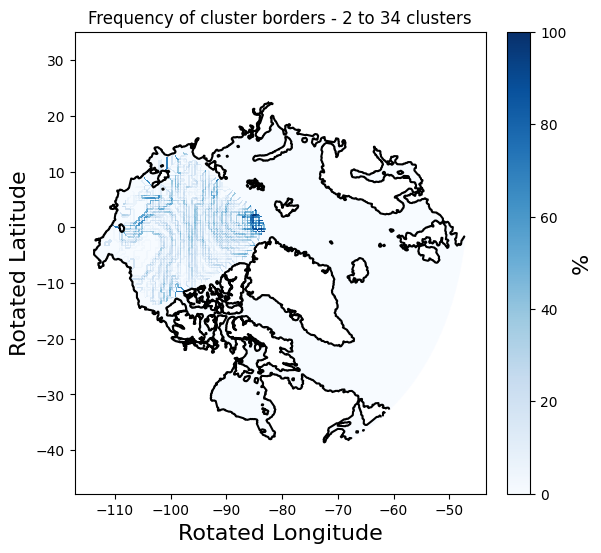

In [20]:
borders_2_10 = process_clusters(2,34)

processing cluster 21
processing cluster 22
processing cluster 23
processing cluster 24
processing cluster 25
processing cluster 26
processing cluster 27
processing cluster 28
processing cluster 29
processing cluster 30
processing cluster 31
processing cluster 32
processing cluster 33
processing cluster 34
processing cluster 35
processing cluster 36
processing cluster 37
processing cluster 38
processing cluster 39
processing cluster 40


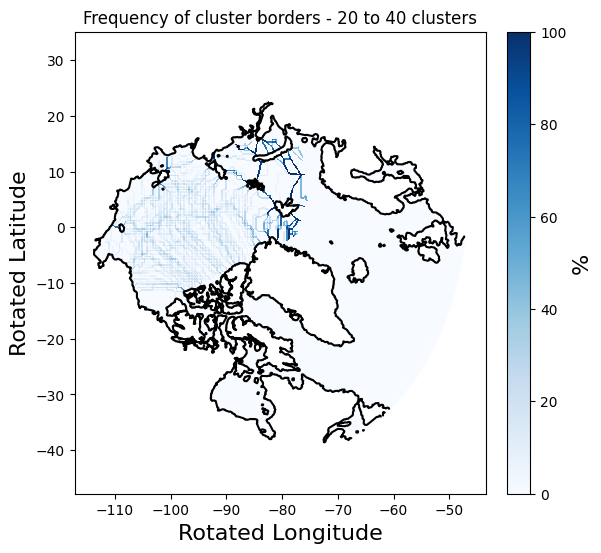

In [24]:
borders_2_10 = process_clusters(20,40)

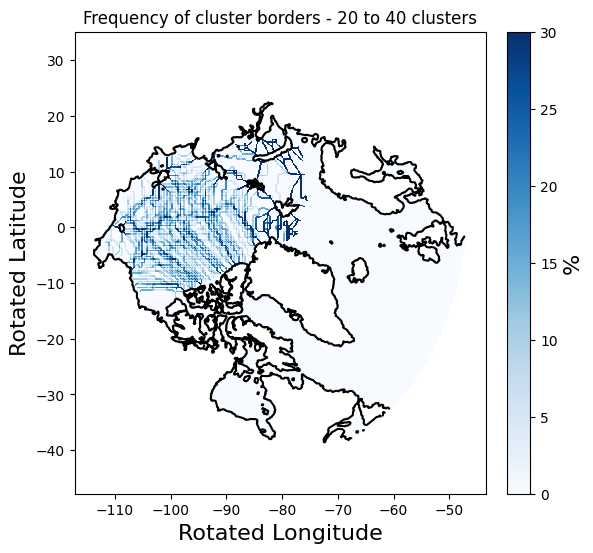

In [26]:
ini_final_clusters_landmask_borders(borders_2_10, results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg, land_mask_plot, 20,40,0,30)

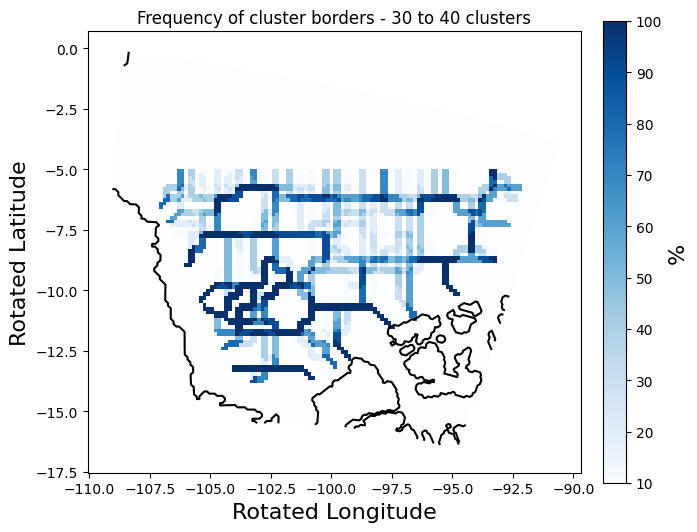

In [18]:
borders_30_40 = process_clusters(30,40)

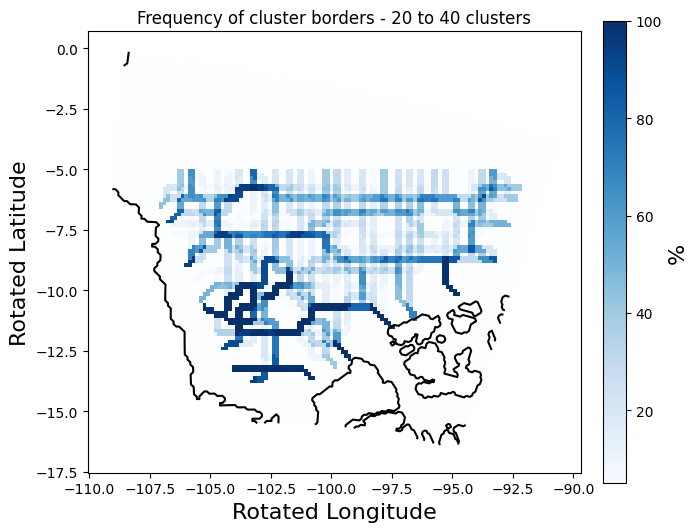

In [19]:
borders_20_40 = process_clusters(20,40)

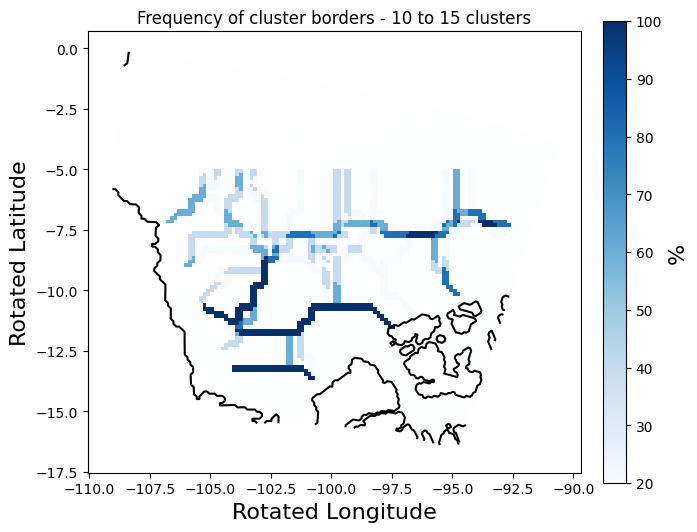

In [20]:
borders_2_10 = process_clusters(10,15)

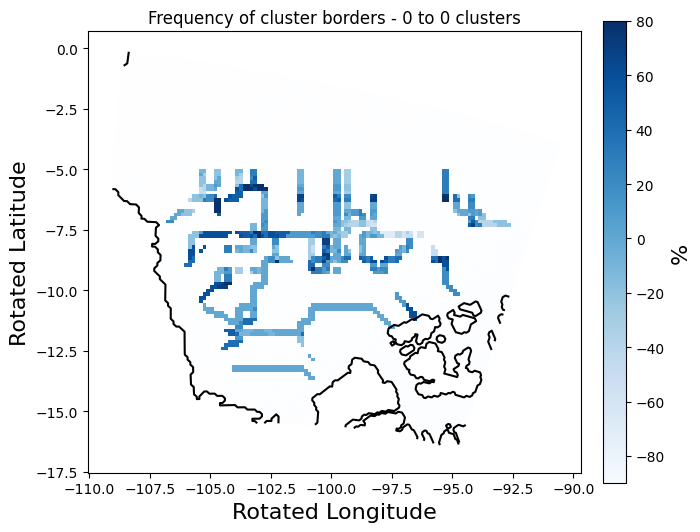

In [21]:
ini_final_clusters_landmask_borders(borders_30_40-borders_2_10, results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg,land_mask_plot, 0,0)

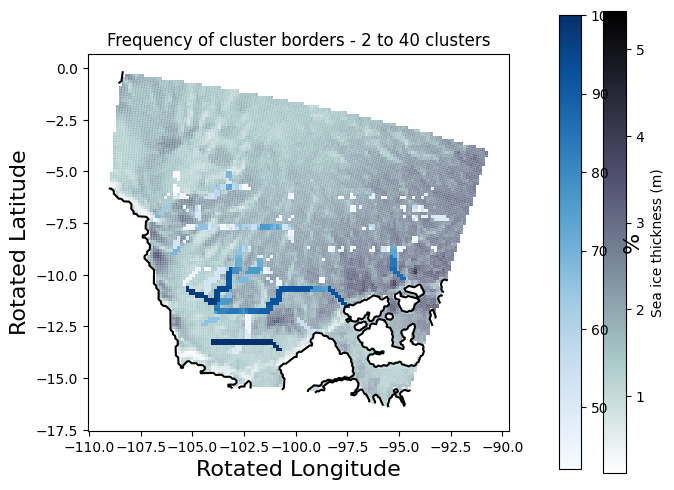

In [37]:
ini_final_clusters_landmask_borders_scalar(borders_2_40,results_directory + "clusters" + Cluster_params + "_blues.png", e, longitude, latitude, x_reg, y_reg,land_mask_plot,2,40,sit)

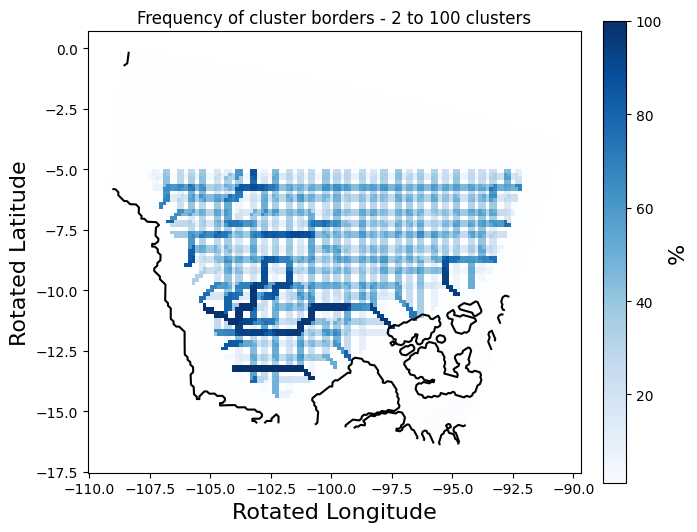

In [27]:
borders_20_40 = process_clusters(2,100)

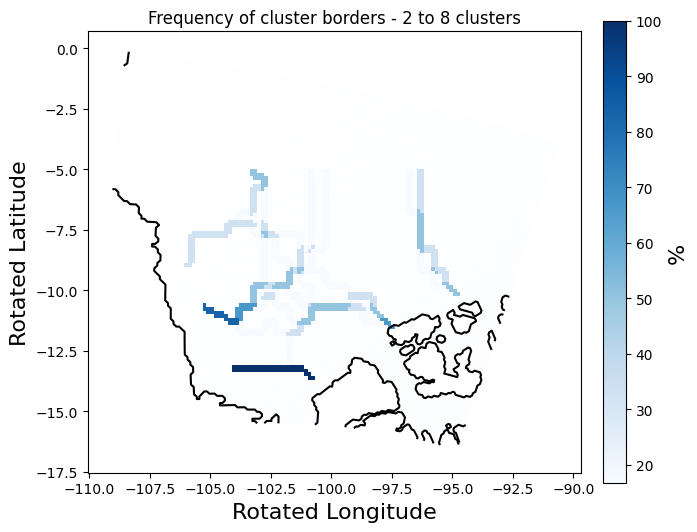

In [33]:
borders_20_40 = process_clusters(2,8)